In [1]:
 import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(7)
pd.set_option("max_rows", None)
pd.set_option("max_columns", None)
sns.set(style="darkgrid")
#将数据分为测试集和训练集
from sklearn.model_selection import train_test_split
# 神经网络模型，使用MLPRegressor，建立多层感知器-回归模型，用于多分类的情况
#只支持交叉熵损失，最小化交叉熵，同时给似然估计p(y|x)
from sklearn.neural_network import  MLPRegressor

## 数据读取

In [390]:
conn = sqlite3.connect('all_house_infos.db')
sql = "select * from HouseInfo "

all_df = pd.read_sql(sql=sql, con=conn)

In [391]:
all_df.shape

(6436, 25)

In [392]:
all_df.head(3)

所属小区     房屋单价   建筑面积  参考首付   建造年代 房屋朝向 参考月供  房屋类型 所在楼层 装修程度 产权年限 配套电梯  \
0      三箭瑞福苑  28448.0  116.0  99.0  2012年    东   暂无  普通住宅   低层   毛坯  70年    有   
1      新泉城名苑  29474.0   95.0  84.0  2015年    南   暂无  普通住宅   中层  精装修  70年    有   
2  绿地IFC中央公馆  23571.0  112.0  79.2  2018年   南北   暂无  普通住宅   高层  精装修  70年    有   

  房本年限   产权性质 唯一住房 一手房源          经度         纬度  房屋户型_室数  房屋户型_厅数  房屋户型_卫数  \
0  满二年  保障性住房    否    否  117.004958  36.657665        3        1        1   
1  满五年  商品房住宅    是    否  116.989272  36.659001        2        2        1   
2   暂无  商品房住宅    是    是  117.111705  36.682556        3        2        1   

   总楼层                                                 图片  \
0   28  https://pages.anjukestatic.com/usersite/site/i...   
1   18  https://pages.anjukestatic.com/usersite/site/i...   
2   25  https://pages.anjukestatic.com/usersite/site/i...   

                                                  链接         总价  
0  https://jinan.anjuke.com/prop/view/A1965502333...  3299968.0  
1  https://jinan.anjuke.com/prop/view/A1974008440...  2800030.0  
2  https://jinan.anjuke.com/prop/view/A1922894672...  2639952.0

## 特征工程

In [393]:
del all_df['参考首付']
del all_df['参考月供']

In [394]:
# 所属小区平均单价
tmp = all_df[['所属小区', '房屋单价']].groupby('所属小区').mean()
tmp = tmp.reset_index()
tmp.columns = ['所属小区', '所属小区平均单价']
tmp.head(3)

所属小区   所属小区平均单价
0  MUM河畔景苑   6474.125
1     丁苑小区  14286.000
2   丁豪蓝调国际  10059.500

In [395]:
# 所属小区房源数
tmp1 = all_df[['所属小区', '房屋单价']].groupby('所属小区').count()
tmp1 = tmp1.reset_index()
tmp1.columns = ['所属小区', '所属小区房源个数']
tmp1.head(3)

所属小区  所属小区房源个数
0  MUM河畔景苑         8
1     丁苑小区         1
2   丁豪蓝调国际         8

In [396]:
tmp = pd.merge(tmp, tmp1, on='所属小区', how='left')

In [ ]:
tmp.head(3)

In [398]:
# 所属小区中心经纬度
tmp2 = all_df[['所属小区', '经度']].groupby('所属小区').mean()
tmp2 = tmp2.reset_index()
tmp2.columns = ['所属小区', '中心经度']

tmp = pd.merge(tmp, tmp2, on='所属小区', how='left')

tmp2 = all_df[['所属小区', '纬度']].groupby('所属小区').mean()
tmp2 = tmp2.reset_index()
tmp2.columns = ['所属小区', '中心纬度']

tmp = pd.merge(tmp, tmp2, on='所属小区', how='left')

tmp.head(3)

所属小区   所属小区平均单价  所属小区房源个数        中心经度       中心纬度
0  MUM河畔景苑   6474.125         8  117.017561  36.723606
1     丁苑小区  14286.000         1  116.982612  36.649212
2   丁豪蓝调国际  10059.500         8  117.102355  36.690472

In [399]:
tmp.to_csv('小区均价房源数和经纬度.csv', index=False, encoding='utf8')

In [400]:
all_df = pd.merge(all_df, tmp, on='所属小区', how='left')

In [401]:
# 建造年代平均单价
tmp = all_df[['建造年代', '房屋单价']].groupby('建造年代').mean()
tmp = tmp.reset_index()
tmp.columns = ['建造年代', '建造年代平均单价']
tmp.head(3)

建造年代      建造年代平均单价
0  1980年  21126.571429
1  1982年  13417.000000
2  1985年  20660.250000

In [402]:
tmp_map = {}
for i, row in tmp.iterrows():
    tmp_map[row['建造年代']] = row['建造年代平均单价']
print(tmp_map)

{'1980年': 21126.571428571428, '1982年': 13417.0, '1985年': 20660.25, '1986年': 18267.0, '1987年': 25267.0, '1988年': 19653.615384615383, '1989年': 17615.75, '1990年': 18921.794520547945, '1991年': 18024.454545454544, '1992年': 20140.022222222222, '1993年': 19312.75, '1994年': 19048.129032258064, '1995年': 18604.570135746606, '1996年': 17822.60824742268, '1997年': 19061.946666666667, '1998年': 18071.160975609757, '1999年': 18075.729411764707, '2000年': 17851.63255033557, '2001年': 19989.174418604653, '2002年': 15449.122807017544, '2003年': 16345.119047619048, '2004年': 16936.28695652174, '2005年': 16370.767857142857, '2006年': 16952.60736196319, '2007年': 15292.27027027027, '2008年': 13548.521126760563, '2009年': 17056.46923076923, '2010年': 16562.82515991471, '2011年': 19416.546875, '2012年': 17531.78605769231, '2013年': 15631.142222222223, '2014年': 16428.931428571428, '2015年': 16552.810650887575, '2016年': 17146.583877995643, '2017年': 16975.844311377245, '2018年': 14942.460714285715, '2019年': 14037.004132231405, '20

In [403]:
all_df = pd.merge(all_df, tmp, on='建造年代', how='left')

In [404]:
all_df['建造年代'] = all_df['建造年代'].map(lambda x: int(x[:-1]) if x != '暂无' else 2015)

In [405]:
chaoxiang_map = {'东':0, '东北':1, '东南':2, '东西':3, '北':4, '南':5, '南北':6, '西':7, '西北':8, '西南':9}
all_df['房屋朝向'] = all_df['房屋朝向'].map(chaoxiang_map)

In [406]:
fangwuleix_map = {'公寓':0, '别墅':1, '平房':2, '普通住宅':3, '暂无':4}
all_df['房屋类型'] = all_df['房屋类型'].map(fangwuleix_map)

In [407]:
suozailouceng_map = {'中层':0, '低层':1, '底层':2, '独栋':3, '高层':4}
all_df['所在楼层'] = all_df['所在楼层'].map(suozailouceng_map)

In [408]:
zhuangxiuchengdu_map = {'毛坯':0, '简单装修':1, '精装修':2, '豪华装修':3}
all_df['装修程度'] = all_df['装修程度'].map(zhuangxiuchengdu_map)

In [409]:
changquannianxian_map = {'40年':0, '50年':1, '70年':2, '暂无':3}
all_df['产权年限'] = all_df['产权年限'].map(changquannianxian_map)

In [410]:
dianti_map = {'无':0, '暂无':0, '有':1}
all_df['配套电梯'] = all_df['配套电梯'].map(dianti_map)

In [411]:
fangbennianxian_map = {'暂无':0, '不满二年':1, '满二年':2, '满五年':3}
all_df['房本年限'] = all_df['房本年限'].map(fangbennianxian_map)

In [412]:
changquanxingzhi_map = {'商住两用': 0, '保障性住房': 1, '单位集体自建房': 2, '其他': 3, '暂无': 4, '使用权': 5, '动迁配套房': 6, '商品房住宅': 7}
all_df['产权性质'] = all_df['产权性质'].map(changquanxingzhi_map)



In [413]:
weiyizhufang_map = {'暂无': 0, '否': 0, '是': 1}
all_df['唯一住房'] = all_df['唯一住房'].map(weiyizhufang_map)

In [414]:
yishoufangyuan_map = {'否': 0, '是': 1}
all_df['一手房源'] = all_df['一手房源'].map(yishoufangyuan_map)

In [415]:
del all_df['所属小区']

## 拆分成训练集和测试集

In [416]:
all_y = all_df['总价'].values
del all_df['总价']
del all_df['房屋单价']
del all_df['中心经度']
del all_df['中心纬度']
del all_df['图片']
del all_df['链接']
all_x = all_df.values

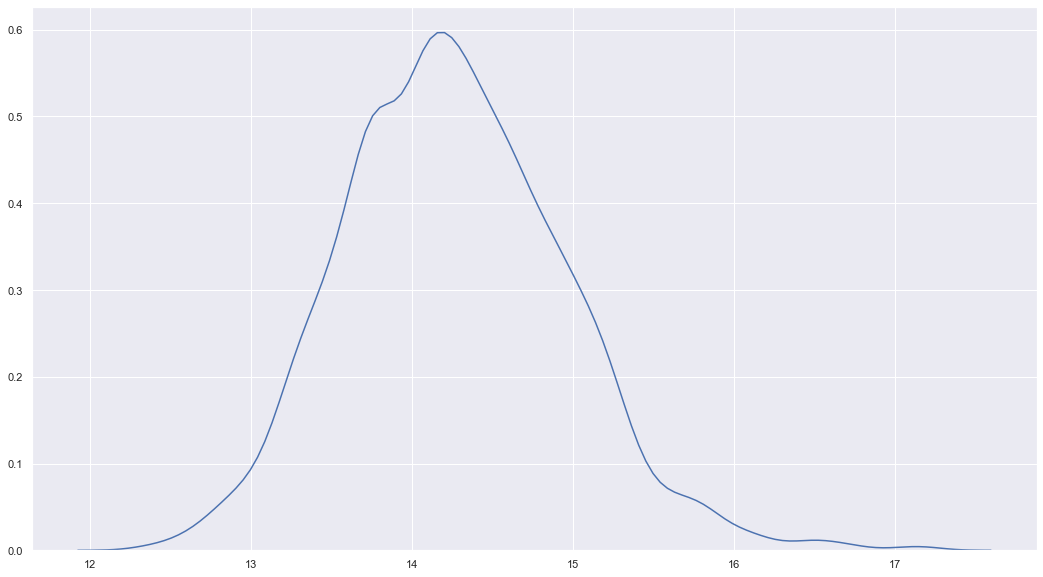

In [417]:
plt.figure(figsize=(18, 10))
sns.kdeplot(np.log1p(all_y))
plt.show()

In [418]:
all_y = np.log1p(all_y)

In [419]:
df_columns = all_df.columns.values.tolist()

In [420]:
train_X, test_X, train_Y, test_Y = train_test_split(all_x, all_y, test_size=0.1, random_state=42)

In [421]:
len(df_columns)

21

In [422]:
df_columns

['建筑面积',
 '建造年代',
 '房屋朝向',
 '房屋类型',
 '所在楼层',
 '装修程度',
 '产权年限',
 '配套电梯',
 '房本年限',
 '产权性质',
 '唯一住房',
 '一手房源',
 '经度',
 '纬度',
 '房屋户型_室数',
 '房屋户型_厅数',
 '房屋户型_卫数',
 '总楼层',
 '所属小区平均单价',
 '所属小区房源个数',
 '建造年代平均单价']

In [423]:
# The error metric: RMSE on the log of the sale prices.
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [424]:
# 构建神经网络模型
neural_net = MLPRegressor(
    hidden_layer_sizes=(32, 8),  activation='relu', solver='adam', alpha=0.0001, batch_size='auto',
    learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=5000, shuffle=True,
    random_state=1, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
    early_stopping=False,beta_1=0.9, beta_2=0.999, epsilon=1e-08
)

In [425]:
# 神经网络模型训练
#使模型适合数据矩阵X和目标y。
neural_net.fit(train_X, train_Y)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(32, 8), learning_rate='constant',
             learning_rate_init=0.001, max_iter=5000, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=1, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [426]:
#使用多层感知器分类器进行预测
predict_test = neural_net.predict(test_X)

In [427]:
predict_price = np.expm1(predict_test)

In [428]:
true_test_price = np.expm1(test_Y)

In [429]:
print('神经网络模型在测试集上的均方误差 RMSE 为：', rmse(test_Y, predict_test))

神经网络模型在测试集上的均方误差 RMSE 为： 1.325220697078773


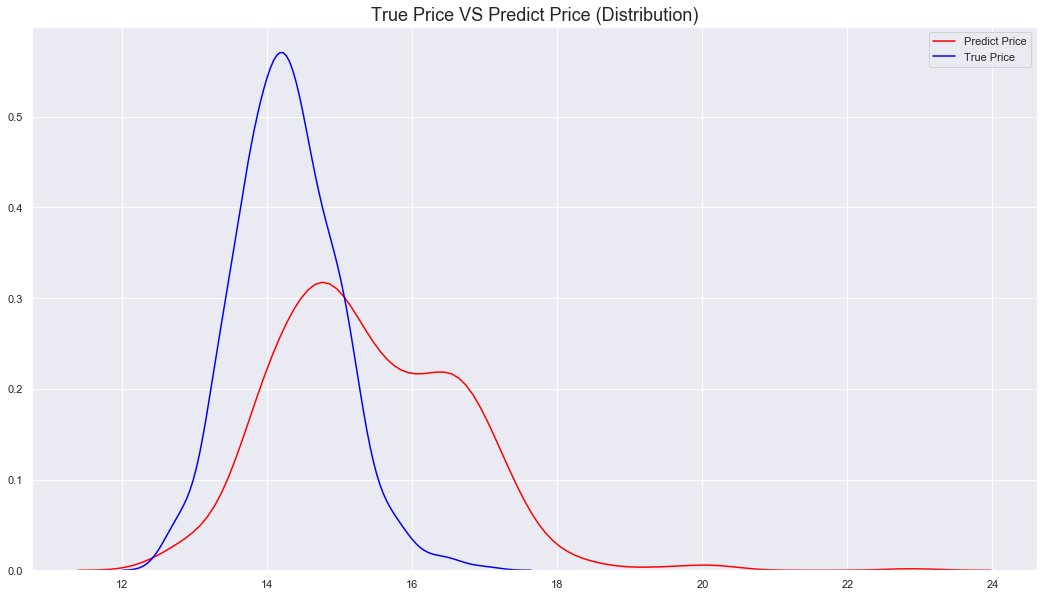

In [430]:
plt.figure(figsize=(18, 10))
sns.kdeplot(predict_test, color='red', label='Predict Price')
sns.kdeplot(test_Y, color='blue', label='True Price')
plt.title('True Price VS Predict Price (Distribution)', size=18)
plt.legend()
plt.show()

## 模型保存

In [431]:
from sklearn.externals import joblib

In [432]:
joblib.dump(neural_net,'neural_net.model')

['neural_net.model']

## 模型加载

In [433]:
neural_net = joblib.load('neural_net.model')

In [434]:
neural_net

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(32, 8), learning_rate='constant',
             learning_rate_init=0.001, max_iter=5000, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=1, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [435]:
predict_test = neural_net.predict(test_X)

In [436]:
predict_price = np.expm1(predict_test)